# Детекция клеток крови

In [6]:
from utils import *
import random
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from model import SSD300, MultiBoxLoss
from datasets import PascalVOCDataset
from tqdm import tqdm
from pprint import PrettyPrinter
from matplotlib import pyplot as plt

In [2]:
create_data_lists(bccd_path='BCCD')


There are 292 training images containing a total of 876 objects. Files have been saved to C:\Users\Miste\YandexDisk\Компьютер DESKTOP-9PMIURO\Moonlight Industries\Программирование\Python\Нетология\Homework_9.

There are 72 test images containing a total of 216 objects. Files have been saved to C:\Users\Miste\YandexDisk\Компьютер DESKTOP-9PMIURO\Moonlight Industries\Программирование\Python\Нетология\Homework_9.


In [3]:
# Data parameters
data_folder = './'  # folder with data files
keep_difficult = True  # use objects considered difficult to detect?

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 8  # batch size
iterations = 900  # number of iterations to train
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 50# print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [500, 700]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True


def main():
    """
    Training.
    """
    global start_epoch, label_map, epoch, checkpoint, decay_lr_at

    # Initialize model or load checkpoint
    if checkpoint is None:
        start_epoch = 0
        model = SSD300(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    # Custom dataloaders
    train_dataset = PascalVOCDataset(data_folder,
                                     split='train',
                                     keep_difficult=keep_difficult)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               collate_fn=train_dataset.collate_fn, num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

    # Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
    # To convert iterations to epochs, divide iterations by the number of iterations per epoch
    # The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations
    epochs = iterations // (len(train_dataset) // 32)
    decay_lr_at = [it // (len(train_dataset) // 32) for it in decay_lr_at]

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate at particular epochs
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training
        train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)

        # Save checkpoint
        save_checkpoint(epoch, model, optimizer)


def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored


if __name__ == '__main__':
    main()


Loaded base model.



C:\Soft\Anaconda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
C:\Soft\Anaconda\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch: [0][0/37]	Batch Time 13.331 (13.331)	Data Time 5.130 (5.130)	Loss 17.3407 (17.3407)	
Epoch: [1][0/37]	Batch Time 7.072 (7.072)	Data Time 6.162 (6.162)	Loss 7.6069 (7.6069)	
Epoch: [2][0/37]	Batch Time 8.098 (8.098)	Data Time 7.252 (7.252)	Loss 4.5644 (4.5644)	
Epoch: [3][0/37]	Batch Time 8.345 (8.345)	Data Time 7.396 (7.396)	Loss 4.0244 (4.0244)	
Epoch: [4][0/37]	Batch Time 9.237 (9.237)	Data Time 8.388 (8.388)	Loss 3.7064 (3.7064)	
Epoch: [5][0/37]	Batch Time 12.081 (12.081)	Data Time 10.953 (10.953)	Loss 3.1208 (3.1208)	
Epoch: [6][0/37]	Batch Time 8.554 (8.554)	Data Time 7.716 (7.716)	Loss 3.4919 (3.4919)	
Epoch: [7][0/37]	Batch Time 9.455 (9.455)	Data Time 8.477 (8.477)	Loss 3.5212 (3.5212)	
Epoch: [8][0/37]	Batch Time 9.550 (9.550)	Data Time 8.672 (8.672)	Loss 3.0401 (3.0401)	
Epoch: [9][0/37]	Batch Time 11.894 (11.894)	Data Time 10.836 (10.836)	Loss 3.2059 (3.2059)	
Epoch: [10][0/37]	Batch Time 10.004 (10.004)	Data Time 9.165 (9.165)	Loss 3.3208 (3.3208)	
Epoch: [11][0/37]

Epoch: [90][0/37]	Batch Time 13.399 (13.399)	Data Time 12.383 (12.383)	Loss 2.2497 (2.2497)	
Epoch: [91][0/37]	Batch Time 14.691 (14.691)	Data Time 13.757 (13.757)	Loss 2.3175 (2.3175)	
Epoch: [92][0/37]	Batch Time 21.536 (21.536)	Data Time 20.483 (20.483)	Loss 2.2035 (2.2035)	
Epoch: [93][0/37]	Batch Time 17.908 (17.908)	Data Time 16.921 (16.921)	Loss 2.2841 (2.2841)	
Epoch: [94][0/37]	Batch Time 12.332 (12.332)	Data Time 11.343 (11.343)	Loss 2.0930 (2.0930)	
Epoch: [95][0/37]	Batch Time 18.654 (18.654)	Data Time 17.575 (17.575)	Loss inf (inf)	
Epoch: [96][0/37]	Batch Time 15.144 (15.144)	Data Time 14.156 (14.156)	Loss 2.1418 (2.1418)	
Epoch: [97][0/37]	Batch Time 15.509 (15.509)	Data Time 14.511 (14.511)	Loss 1.9556 (1.9556)	
Epoch: [98][0/37]	Batch Time 13.017 (13.017)	Data Time 12.088 (12.088)	Loss 2.4254 (2.4254)	
Epoch: [99][0/37]	Batch Time 15.876 (15.876)	Data Time 14.902 (14.902)	Loss 2.3246 (2.3246)	


In [4]:
# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

# Parameters
data_folder = './'
keep_difficult = True  # difficult ground truth objects must always be considered in mAP calculation, because these objects DO exist!
batch_size = 32
workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = './checkpoint_ssd300.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)


def evaluate(test_loader, model):
    """
    Evaluate.
    :param test_loader: DataLoader for test data
    :param model: model
    """

    # Make sure it's in eval mode
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating')):
            images = images.to(device)  # (N, 3, 300, 300)

            # Forward prop.
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

        # Calculate mAP
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

    # Print AP for each class
    pp.pprint(APs)

    print('\nMean Average Precision (mAP): %.3f' % mAP)


if __name__ == '__main__':
    evaluate(test_loader, model)

Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]C:\Users\Miste\YandexDisk\Компьютер DESKTOP-9PMIURO\Moonlight Industries\Программирование\Python\Нетология\Homework_9\model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  image_boxes.append(class_decoded_locs[1 - suppress])
C:\Users\Miste\YandexDisk\Компьютер DESKTOP-9PMIURO\Moonlight Industries\Программирование\Python\Нетология\Homework_9\model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  image_scores.append(class_scores[1 - suppress])
Evaluating: 100%|█████████████████████████

{'platelets': 0.6914922595024109,
 'rbc': 0.7964069247245789,
 'wbc': 0.9754237532615662}

Mean Average Precision (mAP): 0.821



Loaded checkpoint from epoch 100.



C:\Soft\Anaconda\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
C:\Users\Miste\YandexDisk\Компьютер DESKTOP-9PMIURO\Moonlight Industries\Программирование\Python\Нетология\Homework_9\model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  image_boxes.append(class_decoded_locs[1 - suppress])
C:\Users\Miste\YandexDisk\Компьютер DESKTOP-9PMIURO\Moonlight Industries\Программирование\Python\Нетология\Homework_9\model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  C:\actions-run

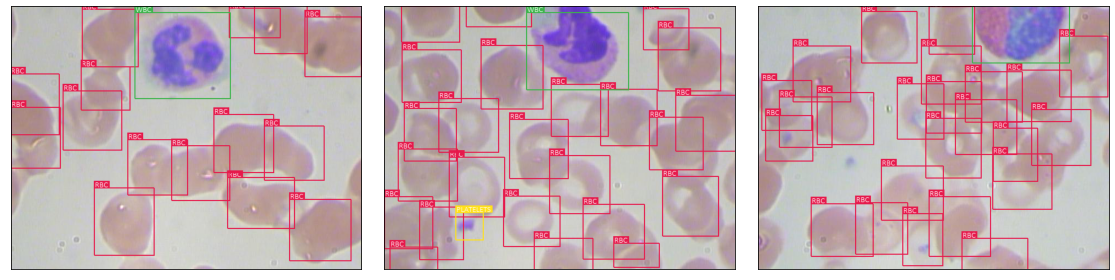

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.
    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./calibril.ttf", 15)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image

if __name__ == '__main__':
    fig = plt.figure(figsize=(16, 4))
    for i in range(0, 3):
        path='BCCD/JPEGImages/'
        img_name = ''
        while img_name not in os.listdir(path=path):
            img_name = 'BloodImage_' + '{:0>5}'.format(random.randint(0, 411)) + '.jpg'
        img_path = path + img_name
        original_image = Image.open(img_path, mode='r')
        original_image = original_image.convert('RGB')
        fig.add_subplot(1, 3, i+1)
        plt.imshow(detect(original_image, min_score=0.15, max_overlap=0.3, top_k=200))
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()